참고 : https://huggingface.co/transformers/master/custom_datasets.html  
참고 : https://towardsdatascience.com/fine-tuning-hugging-face-model-with-custom-dataset-82b8092f5333

KLUE BERT를 사용하는 코드에서 모델과 토크나이저와 옵티마이저만 변경한 코드.

# 데이터 전처리

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f3c53789c10>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [ ]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [ ]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [ ]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [ ]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


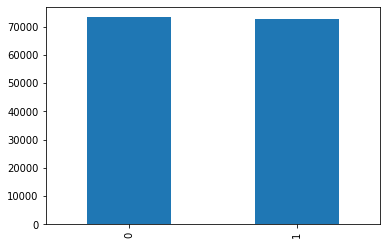

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [ ]:
print(train_data.isnull().values.any())

True


In [ ]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [ ]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [ ]:
print(len(train_data))

146182


# 토크나이저를 이용한 정수 인코딩

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 7.7 MB/s 
     |████████████████████████████████| 3.3 MB 67.0 MB/s 
     |████████████████████████████████| 895 kB 85.4 MB/s 
     |████████████████████████████████| 636 kB 76.6 MB/s 
     |████████████████████████████████| 50 kB 8.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import transformers

In [ ]:
transformers.__version__

'4.10.2'

In [ ]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("klue/roberta-large")

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

In [ ]:
test_data = test_data.dropna(how = 'any')

In [ ]:
print(len(test_data))

49997


In [ ]:
X_train_list = train_data['document'].tolist()
X_test_list = test_data['document'].tolist()
y_train = train_data['label'].tolist()
y_test = test_data['label'].tolist()

In [ ]:
X_train = tokenizer(X_train_list, truncation=True, padding=True)
X_test = tokenizer(X_test_list, truncation=True, padding=True)

In [ ]:
print(X_train[0].tokens)

['[CLS]', '아', '더', '##빙', '.', '.', '진짜', '짜증', '##나', '##네', '##요', '목소리', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

In [ ]:
print(X_train[0].ids)

[0, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
print(X_train[0].type_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(X_train[0].attention_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# 데이터셋 생성 및 모델 학습

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train),
    
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test),
    y_test
))

In [ ]:
import os

In [ ]:
from transformers import TFRobertaForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from transformers import AdamWeightDecay

In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
optimizer = AdamWeightDecay(1e-5, weight_decay_rate=1e-4)

In [ ]:
model = TFRobertaForSequenceClassification.from_pretrained("klue/roberta-base", num_labels=2, from_pt=True)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
model.compute_loss

<bound method TFSequenceClassificationLoss.compute_loss of <transformers.models.roberta.modeling_tf_roberta.TFRobertaForSequenceClassification object at 0x7f3b9f6c7a90>>

In [ ]:
model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  110027520 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  592130    
Total params: 110,619,650
Trainable params: 110,619,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
inputs = tokenizer("이 영화 개노잼", return_tensors="tf")
inputs["labels"] = tf.reshape(tf.constant(1), (-1, 1)) # Batch size 1

outputs = model(inputs)
loss = outputs.loss
logits = outputs.logits

In [ ]:
loss

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.82362944], dtype=float32)>

In [ ]:
outputs.logits

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.1678046 , -0.07808262]], dtype=float32)>

In [ ]:
model.fit(
    train_dataset.shuffle(10000).batch(32), epochs=5,
    validation_data = val_dataset.shuffle(10000).batch(32),
)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

KeyboardInterrupt: ignored

# 모델 저장

In [ ]:
MODEL_NAME = 'naver-movie-roberta-base'
MODEL_SAVE_PATH = os.path.join("_model", MODEL_NAME) # change this to your preferred location

if os.path.exists(MODEL_SAVE_PATH):
    print(f"{MODEL_SAVE_PATH} -- Folder already exists \n")
else:
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
    print(f"{MODEL_SAVE_PATH} -- Folder create complete \n")

# save tokenizer, model
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

_model/naver-movie-roberta-base -- Folder create complete 



('_model/naver-movie-roberta-base/tokenizer_config.json',
 '_model/naver-movie-roberta-base/special_tokens_map.json',
 '_model/naver-movie-roberta-base/vocab.txt',
 '_model/naver-movie-roberta-base/added_tokens.json',
 '_model/naver-movie-roberta-base/tokenizer.json')

In [ ]:
MODEL_SAVE_PATH

'_model/naver-movie-roberta-base'

# 모델 로드 및 테스트

In [ ]:
from transformers import TextClassificationPipeline

# 로드하기
loaded_tokenizer = BertTokenizerFast.from_pretrained(MODEL_SAVE_PATH)
loaded_model = TFRobertaForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    return_all_scores=True
)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at _model/naver-movie-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [ ]:
text_classifier('뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아')[0]

[{'label': 'LABEL_0', 'score': 0.6196238994598389},
 {'label': 'LABEL_1', 'score': 0.38037607073783875}]

In [ ]:
text_classifier('오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함')[0]

[{'label': 'LABEL_0', 'score': 0.015164303593337536},
 {'label': 'LABEL_1', 'score': 0.984835684299469}]

In [ ]:
model.evaluate(val_dataset.batch(1024))

49/49 [==============================] - 196s 4s/step - loss: 0.2409 - accuracy: 0.9037


[0.240866020321846, 0.903694212436676]